Scipy dendrograms vs. Astrodendro
=================================

First, let's get the imports out of the way

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree
from astrodendro import Dendrogram

Next, let's define some data with some some Gaussian peaks

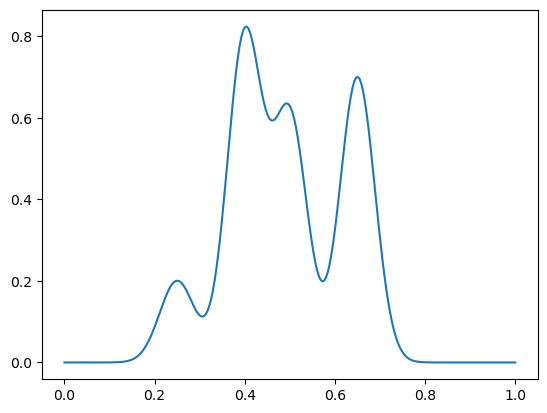

In [2]:
x = np.linspace(0, 1, 256)

peaks = [0.25, 0.4, 0.5, 0.65]
heights = [0.2, 0.8, 0.6, 0.7]

data = np.zeros_like(x)
for peak, height in zip(peaks, heights):
    data += height * np.exp(-((x - peak) ** 2) / 0.003)

plt.plot(x, data)

Ok, what does Astrodendro do with this data?

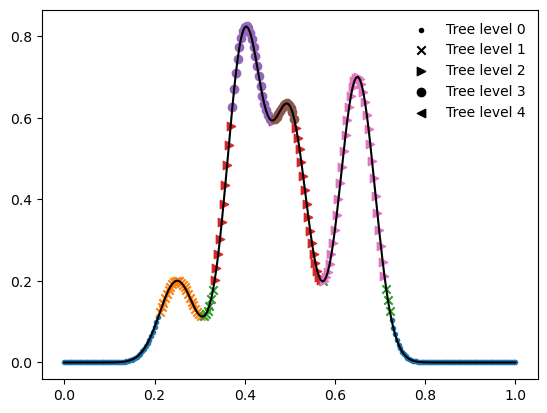

In [3]:
d = Dendrogram.compute(data)
markers = {0: ".", 1: "x", 2: ">", 3: "o", "4": "<"}


def plot_dendrogram_leaves(leaves, level=0):
    for leaf in leaves:
        plt.scatter(x[leaf._indices], data[leaf._indices], marker=markers[level])
        plot_dendrogram_leaves(leaves=leaf._children, level=level + 1)


plt.plot(x, data, color="black")
plot_dendrogram_leaves(d.trunk, level=0)

for level in markers.keys():
    plt.scatter(
        [None],
        [None],
        marker=markers[level],
        label=f"Tree level {level}",
        color="black",
    )
plt.legend(frameon=False)

Astrodendro computes a tree structure. Sadly, I don't know how to plot the tree in this plot.
The markerstyles denote the level in the tree and the colors denote individual features.

As you can see, leaves begin at a local minimum and encapsulate a local maximum.
They are joined to branches at local minima.

Ok, now let's see if we can replicate this with scipy methods.

Scipy has methods for hierarchical clustering that work by some "distance" or dissimilarity between the data.
Astrodendro, on the other hand, identifies structures by some flux or other physical quantity.
So the question is: Can we define a dissimilarity function that reproduces the Astrodendro clustering in Scipy?

As a first try, we can simply count local minima and cluster everything in between two local minima.
To do this, we first approximate the derivative using a simple first order finite difference method: $\partial_x f(x) \approx (f(x+\Delta x) - f(x)) / \Delta x$.
Then, we look at the sign of the derivative.
In the numerical approximation, roots of the derivative will likely not fall on grid points, so we find where they are by looking for sign changes.
This is only a rough approximation, but should be good enough for clustering.
The dissimilarity is then every other sign change.

Text(0, 0.5, 'dissimilarity')

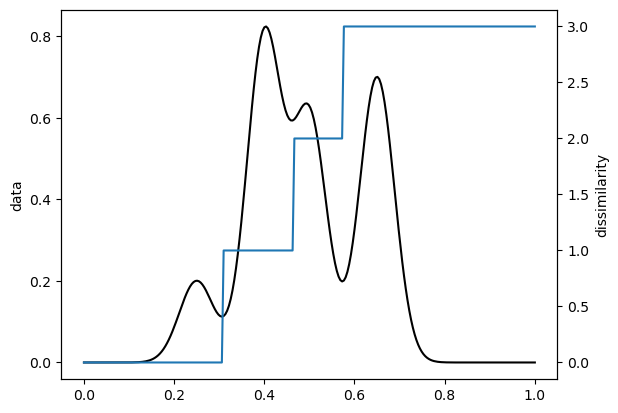

In [4]:
deriv = np.append(
    (data[0] - data[1]) / (x[0] - x[1]), (data[1:] - data[:-1]) / (x[1:] - x[:-1])
)
sign = np.sign(deriv)
sign_change = np.cumsum(np.append([0], -(sign[1:] / sign[:-1] - 1) / 2))
dissimilarity = (sign_change - sign_change % 2) / 2

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(x, data, color="black")
ax2.plot(x, dissimilarity)
ax.set_ylabel("data")
ax2.set_ylabel("dissimilarity")

We see that all data between two local minima has the same amount of dissimilarity, which means they will be clustered together.
Let's use the scipy `linkage` function to compute the tree and plot the result:

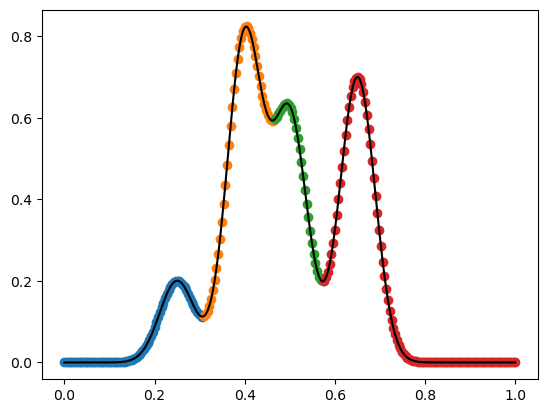

In [5]:
plt.plot(x, data, color="black")
Z = linkage(dissimilarity[:, np.newaxis], "single")
labels = cut_tree(Z, n_clusters=len(peaks)).flatten()
for l in np.unique(labels):
    mask = labels == l
    plt.scatter(x[mask], data[mask])

This is a good start.
We have managed to cluster the areas around local maxima and separated them at local minima.
However, the tree structure is still an open problem.
This has only identified the leaves and assigned everything to a leaf, whereas Astrodendo would assign most of this to branches.
So the dissimilarity function needs to include some more information!